<a href="https://colab.research.google.com/github/Giusgarus/ISPR-assignment/blob/main/Third/assignment_3(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2, Giuseppe Gabriele Russo 583744

DATASET (HORSES): www.kaggle.com/datasets/ztaihong/weizmann-horse-database/data

Implement your own convolutional network to solve problem of horse semantic segmentation from the background in the Horses Dataset. Choose your favourite convolutional-type architecture to solve the problem and motivate your choice. The design decisions about how many layers, the type of layers and how they are interleaved, the type of pooling, the use of residual connections, etc. are also on you.  Train and validate the model on the data as appropriate in Machine Learning an provide a measure of segmentation accuracy.

## Import and dataset download

In [ ]:
# Install the required libraries silently (without output)
!pip install -q opendatasets
!pip install -q colorama  # Optional: for colored console output, if needed later

# Import the opendatasets library to download datasets from Kaggle
import opendatasets as od

# Download the Weizmann Horse Database from Kaggle
od.download("https://www.kaggle.com/datasets/ztaihong/weizmann-horse-database")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ztaihong/weizmann-horse-database


In [ ]:
import os
import glob
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from colorama import init, Fore, Style
import matplotlib.pyplot as plt
import numpy as np

## Pre-processing

This cell defines a PyTorch `Dataset` subclass used to load image-mask pairs for semantic segmentation.  

- **HorseSegmentationDataset** loads grayscale images and corresponding binary masks from the dataset.
- It applies the specified transformations (resize + normalization) to both.
- The mask is binarized by thresholding pixel values greater than 0 (after normalization).
- The `transform` resizes each image and mask to 256×256 and converts them to tensors with values in [0, 1].
- Image and mask paths are loaded and sorted to ensure matching pairs.

In [ ]:
# Custom PyTorch Dataset for horse segmentation
class HorseSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths  # List of paths to input images
        self.mask_paths = mask_paths    # List of paths to corresponding masks
        self.transform = transform      # Optional transformation (resize + ToTensor)

    def __len__(self):
        return len(self.image_paths)    # Number of samples in the dataset

    def __getitem__(self, idx):
        # Load image and mask in grayscale
        image = Image.open(self.image_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        # Apply transformations if defined (resize + tensor conversion)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Binarize the mask: convert pixels > 0 to 1.0 (others remain 0.0)
        mask = (mask > 0.001).float()

        return image, mask  # Return image and binary mask tensors

# Define transformations: resize to 256x256 and convert to tensor in [0, 1]
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load and sort all image and mask file paths
image_paths = sorted(glob.glob("weizmann-horse-database/weizmann_horse_db/horse/*.png"))
mask_paths = sorted(glob.glob("weizmann-horse-database/weizmann_horse_db/mask/*.png"))

This cell splits the full dataset into **training**, **validation**, and **test** sets using an 80/10/10 split strategy.

- The first `train_test_split` creates an 80% training and 20% test split.
- The second split further divides the training set into 80% training and 20% validation (i.e., 64% train, 16% val, 20% test overall).
- Three separate `HorseSegmentationDataset` objects are created for each split.
- PyTorch `DataLoader` objects are created to load each dataset in batches.

In [ ]:
# Split into 80% training and 20% test
train_img, test_img, train_mask, test_mask = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)

# Further split training set into 80% training and 20% validation
train_img, val_img, train_mask, val_mask = train_test_split(
    train_img, train_mask, test_size=0.2, random_state=42)

# Create Dataset objects for training, validation, and test sets
train_dataset = HorseSegmentationDataset(train_img, train_mask, transform=transform)
val_dataset = HorseSegmentationDataset(val_img, val_mask, transform=transform)
test_dataset = HorseSegmentationDataset(test_img, test_mask, transform=transform)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)   # shuffle training data
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)      # no need to shuffle validation
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)    # no need to shuffle test

## U-Net Architecture for Semantic Segmentation

This cell defines a custom implementation of the U-Net architecture using PyTorch.

- The model is fully convolutional, designed to output a pixel-wise binary segmentation mask.
- The `conv_block` method defines a repeated convolution → batch norm → ReLU pattern used throughout.
- The `forward` method implements the full encoder-decoder structure with skip connections.
- Max pooling is used for downsampling, and transposed convolutions for upsampling.
- Skip connections (via `torch.cat`) allow the decoder to reuse features from the encoder, improving spatial precision.

In [ ]:
# Custom U-Net architecture for binary semantic segmentation
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder: 4 blocks of conv + batchnorm + ReLU
        self.enc1 = self.conv_block(1, 64)      # input: 1 channel (grayscale), output: 64 features
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Pooling layer used between encoder blocks
        self.pool = nn.MaxPool2d(2)

        # Decoder: upsampling + conv blocks with skip connections
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)  # upsample
        self.dec3 = self.conv_block(512, 256)                 # concat(upsampled, e3) → 512 channels

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self.conv_block(256, 128)                 # concat(upsampled, e2)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self.conv_block(128, 64)                  # concat(upsampled, e1)

        # Final 1x1 conv layer to reduce to 1 output channel (sigmoid = probability map)
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_c, out_c):
        # Two 3x3 convolutions, each followed by batch normalization and ReLU
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder path (contracting)
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Decoder path (expanding) with skip connections
        d3 = self.up3(e4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))  # concat with encoder output e3

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))  # concat with e2

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))  # concat with e1

        # Final output activation: pixel-wise probability (sigmoid)
        return torch.sigmoid(self.final(d1))

## IoU Metric Function (Intersection over Union)

This function computes the **IoU score** (Intersection over Union) between predicted masks and ground truth masks.

- IoU is a commonly used metric for evaluating segmentation accuracy.
- It measures the overlap between the predicted mask and the true mask.
- The prediction is binarized using a threshold (default = 0.5).
- The function supports batch inputs and returns the **mean IoU** over the batch.

In [ ]:
# Computes mean Intersection over Union (IoU) for a batch of predictions and targets
def iou_score(preds, targets, threshold=0.5):
    # Binarize predictions and targets using given thresholds
    preds = (preds > threshold).float()
    targets = (targets > 0.5).float()

    # Compute intersection: pixels where both pred and target are 1
    intersection = (preds * targets).sum(dim=(1, 2, 3))

    # Compute union: pixels where either pred or target is 1
    union = ((preds + targets) >= 1).float().sum(dim=(1, 2, 3))

    # Compute IoU for each sample in the batch, avoid division by zero
    iou = (intersection + 1e-6) / (union + 1e-6)

    # Return mean IoU over the batch
    return iou.mean().item()

### IoU for a Single Image-Mask Pair

This function computes the **IoU (Intersection over Union)** between a single predicted mask and its corresponding ground truth mask.

- It is designed for individual mask evaluation (e.g., during visualization).
- Inputs are NumPy arrays, not PyTorch tensors.
- Predictions and targets are binarized using a specified threshold.
- The IoU value ranges from 0 (no overlap) to 1 (perfect overlap).

In [ ]:
# Computes the IoU between a single predicted mask and its ground truth (NumPy arrays)
def iou_score_single(pred, target, threshold=0.5):
    """
    Computes the IoU for a single predicted mask and ground truth mask.
    """
    # Binarize prediction and ground truth using the specified threshold
    pred = (pred > threshold).astype(float)
    target = (target > 0.5).astype(float)

    # Calculate intersection (where both pred and target equal 1)
    intersection = (pred * target).sum()

    # Calculate union (where either pred or target is 1)
    union = ((pred + target) >= 1).astype(float).sum()

    # Compute IoU and avoid division by zero
    iou = (intersection + 1e-6) / (union + 1e-6)

    return iou

## Visualize Model Predictions with IoU

This function displays a given number `n` of segmentation predictions from a DataLoader.

- It sets the model to evaluation mode and disables gradient computation.
- For each batch, it processes the images through the model and extracts predictions.
- It displays 3 images per example:
  1. The input image (grayscale)
  2. The ground truth mask
  3. The predicted mask (thresholded) with its IoU value
- The function stops after showing `n` examples across batches.

In [ ]:
# Visualizes n predictions from a DataLoader along with their IoU scores
def plot_predictions(model, loader, device, n=6, threshold=0.5):
    """
    Displays n predictions with their corresponding IoU values.
    """
    model.eval()  # set model to evaluation mode
    shown = 0     # counter for displayed images

    with torch.no_grad():  # disable gradient computation
        for images, masks in loader:
            images = images.to(device)
            preds = model(images).cpu().numpy()   # get model predictions as numpy
            masks = masks.cpu().numpy()           # move masks to CPU for plotting

            for i in range(images.shape[0]):
                if shown >= n:
                    return  # stop when desired number of images has been shown

                # Extract prediction and ground truth mask for one image
                pred_mask = preds[i][0]
                true_mask = masks[i][0]

                # Compute IoU for this image
                iou = iou_score_single(pred_mask, true_mask, threshold)

                # Create a figure with input, ground truth, and prediction
                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.imshow(images[i][0].cpu(), cmap='gray')
                plt.title('Input Image')

                plt.subplot(1, 3, 2)
                plt.imshow(true_mask, cmap='gray')
                plt.title('Ground Truth')

                plt.subplot(1, 3, 3)
                plt.imshow(pred_mask > threshold, cmap='gray')
                plt.title(f'Prediction (IoU = {iou:.3f})')

                plt.tight_layout()
                plt.show()

                shown += 1  # increment displayed image count

## Training Loop with Early Stopping and IoU Monitoring

This block performs the training of the U-Net model over multiple epochs, using **Binary Cross Entropy (BCE)** as the loss function and **Adam** as the optimizer.

Key features:
- The model trains on batches from the training DataLoader and evaluates on the validation set.
- At each epoch, both **loss** and **IoU score** are computed for validation.
- **Early stopping** is applied to prevent overfitting:
  - If validation loss does not improve for `patience` epochs, training is stopped early.
  - The best-performing model (lowest val loss) is saved and restored at the end.

This ensures that the model stops training once it reaches the point where continued training no longer yields better generalization.

In [ ]:
# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the U-Net model, binary cross-entropy loss, and Adam optimizer
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training configuration
num_epochs = 40
patience = 5                          # early stopping patience
counter = 0                           # tracks epochs without improvement
best_val_loss = float('inf')         # best observed validation loss
train_losses, val_losses = [], []    # lists to store loss values

# Start training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Training phase
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))  # average train loss

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)

            loss = criterion(preds, masks)
            val_loss += loss.item()

            # Compute batch IoU and accumulate
            val_iou += iou_score(preds, masks)

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)
    val_losses.append(val_loss)

    # Print progress with color (requires `colorama`)
    print(Fore.GREEN + f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_loss:.4f} - Val IoU: {val_iou:.4f}" + Style.RESET_ALL)

    # Early stopping logic: check if validation loss improved
    if val_loss < best_val_loss - 1e-4:  # improved by more than threshold
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()  # save best model
    else:
        counter += 1
        print(Fore.YELLOW + f" Early stopping counter: {counter}/{patience}" + Style.RESET_ALL)
        if counter >= patience:
            print(Fore.RED + "Early stopping triggered." + Style.RESET_ALL)
            break

# Restore best model weights after early stopping
model.load_state_dict(best_model_state)

Epoch 1/40 - Train Loss: 0.5689 - Val Loss: 0.5865 - Val IoU: 0.4313
Epoch 2/40 - Train Loss: 0.4269 - Val Loss: 0.3844 - Val IoU: 0.5692
Epoch 3/40 - Train Loss: 0.3552 - Val Loss: 0.3067 - Val IoU: 0.6186
Epoch 4/40 - Train Loss: 0.3054 - Val Loss: 0.2868 - Val IoU: 0.6781
Epoch 5/40 - Train Loss: 0.2880 - Val Loss: 0.5199 - Val IoU: 0.5634
 Early stopping counter: 1/5
Epoch 6/40 - Train Loss: 0.2526 - Val Loss: 0.2712 - Val IoU: 0.7209
Epoch 7/40 - Train Loss: 0.2295 - Val Loss: 0.2911 - Val IoU: 0.6954
 Early stopping counter: 1/5
Epoch 8/40 - Train Loss: 0.2121 - Val Loss: 0.2219 - Val IoU: 0.7591
Epoch 9/40 - Train Loss: 0.1931 - Val Loss: 0.2322 - Val IoU: 0.7563
 Early stopping counter: 1/5
Epoch 10/40 - Train Loss: 0.1791 - Val Loss: 0.2189 - Val IoU: 0.7638
Epoch 11/40 - Train Loss: 0.1640 - Val Loss: 0.2000 - Val IoU: 0.7705
Epoch 12/40 - Train Loss: 0.1558 - Val Loss: 0.3363 - Val IoU: 0.6811
 Early stopping counter: 1/5
Epoch 13/40 - Train Loss: 0.1487 - Val Loss: 0.1847 -

<All keys matched successfully>

## Qualitative Evaluation on Test Set (n = 3)

Below we present three segmentation examples produced by the model on test images.  
Each row contains:
- The input grayscale image.
- The ground truth binary mask.
- The predicted binary mask with the computed IoU score.

### Result Analysis:

- **First image (IoU = 0.776)**:  
  The model correctly identifies the horse's shape and general structure, but some finer details such as leg contours and parts near the edges are incomplete. Background elements (like waves) may have slightly interfered with prediction. Still, the overall segmentation is reasonably good.

- **Second image (IoU = 0.546)**:  
  This is a more difficult case. The prediction includes large background regions (e.g., grass or fence shadows), leading to over-segmentation. While the horse's body is partially detected, artifacts in the lower area heavily reduce precision. This highlights the model’s sensitivity to complex textures and contrasts.

- **Third image (IoU = 0.896)**:  
  An excellent segmentation result. The predicted mask closely follows the ground truth, with clean contours and minimal false positives. This image likely had favorable lighting, contrast, and a clear horse silhouette — all factors that help the model generalize effectively.

These results show that while the model performs very well in clean and simple scenarios, performance drops in visually complex or noisy scenes. Incorporating more robust preprocessing or training with augmented data could improve consistency across cases.

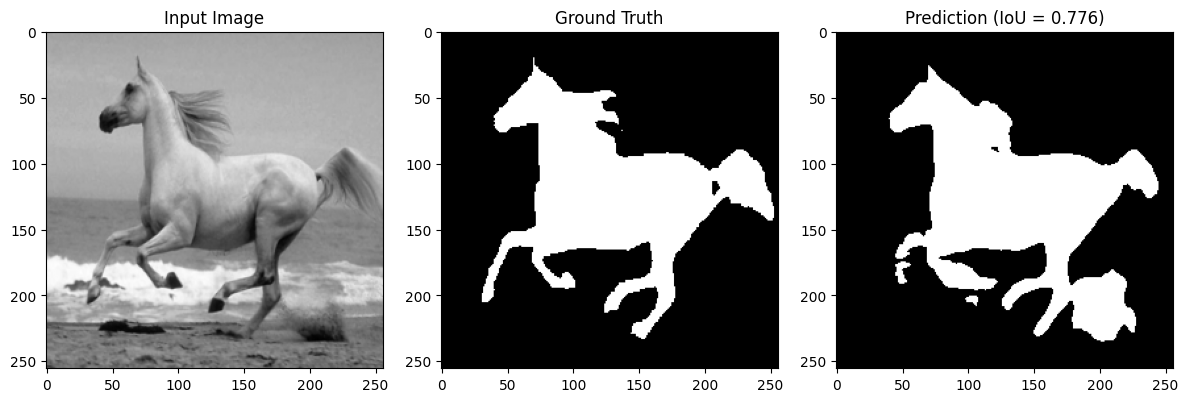

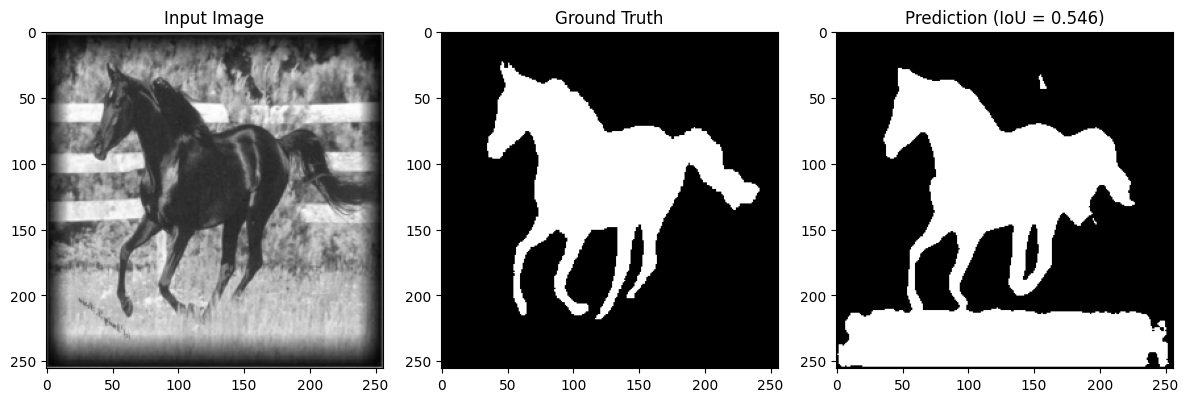

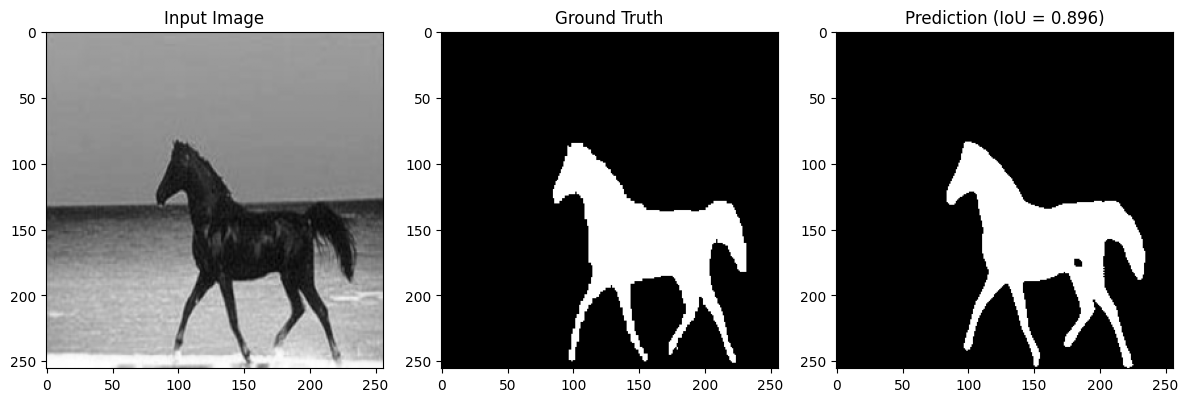

In [ ]:
# Visualizes n predictions from the test set and prints their IoU scores
plot_predictions(model, test_loader, device, n=3)

## Conclusions

The semantic segmentation model based on U-Net has demonstrated strong performance on the Weizmann Horse Dataset.

At its final training epoch (32/40), the model achieved:

- **Training Loss**: 0.0478  
- **Validation Loss**: 0.1355  
- **Validation IoU**: 0.8349  

These metrics indicate that:
- The model is able to **learn meaningful representations** of the horse vs. background segmentation task.
- The relatively low **training and validation loss** suggests that overfitting has been controlled, also thanks to early stopping.
- An **IoU of ~0.83** on validation is a good indicator of segmentation quality, especially given the diversity of horse poses and backgrounds.

### Additional insights:
- **Qualitative results** confirm that the model performs very well on standard, high-contrast images.
- However, performance may degrade on images with **unusual lighting or complex backgrounds**, as shown by examples with IoU scores below 0.6.
- Skip connections in the U-Net architecture proved essential to preserve fine details, particularly around object boundaries.

### Possible improvements:
- Introduce **data augmentation** (rotation, brightness, noise) to improve robustness.
- Experiment with **combined loss functions** (e.g., BCE + Dice) to better handle class imbalance.
- Use **transfer learning** with a pretrained encoder backbone for better generalization.

In conclusion, U-Net has proven to be an effective and reliable architecture for binary segmentation of horses from the background, achieving both **quantitative accuracy** and **qualitative quality** in its predictions.